# Driver Identification and Transport Mode Classification using ResNet50-GRU and BiLSTM MTL model
To better understand the code, check out `./prep_files/MultiTaskModel.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import random_split, DataLoader

from src.engine import MTL_engine
from src.model_multitask import MultitaskModel
from src.plot import MTL_plot
from src.dataset import CombinedDataset

#### Computing class weights for both tasks

***driver identification***

In [2]:
y_train = pd.read_csv('./data/feature_maps_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights_dr = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights_dr = class_weights_dr / class_weights_dr.sum()
class_weights_dr = class_weights_dr.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights_dr)
del y_train

Classes: [0 1 2 3]
Class weights: tensor([0.0153, 0.2646, 0.1717, 0.5485], device='cuda:0')


Driver Id Class labels = [`'Not_driving'`, `'User1'`, `'User2'`, `'User3'`]

***transport mode classification***

In [3]:
y_train = pd.read_csv('./data/lstm_features_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights_tr = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights_tr = class_weights_tr / class_weights_tr.sum()
class_weights_tr = class_weights_tr.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights_tr)
del y_train

Classes: [0. 1. 2. 3. 4. 5. 6. 7.]
Class weights: tensor([0.0521, 0.0592, 0.4732, 0.1143, 0.0655, 0.1070, 0.0639, 0.0648],
       device='cuda:0')


Class labels for driver identification. Note that label 0 (Null) was removed during preprocessing and `1` was subtracted from all labels so that it labels start from `0`.

Transport class labels: [`'Still'`, `'Walking'`, `'Run'`, `'Bike'`, `'Car'`, `'Bus'`, `'Train'`, `'Subway'`]

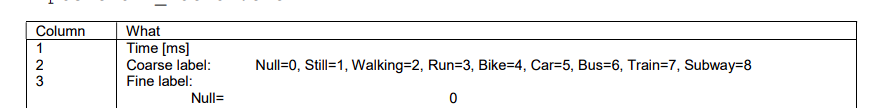

### 1. First run with desirable config

In [4]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(42)

train_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='train', 
                                 rescale=False, augment=True)
val_test_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='valid',
                                 rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 128
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [5]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [6]:
criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [7]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

validation loss < training loss because of dropout. [*StackExchange*](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error)

Train time: 345mins

In [8]:
firstRun_hist = engine.train_validation(train_dl, valid_dl, epochs=50, alpha=1, beta=1,
                                        save_path='./model_checkpoint/run1_MTL_model_chkpt.pth')

np.save('./model_checkpoint/run1_MTL_model_history.npy', np.array(firstRun_hist))

Epoch [1/50], Train Loss: 2.7143, Train Transport Acc: 27.64%, Train Driver Acc: 51.85%, Val Loss: 2.1116, Val Transport Acc: 38.69%, Val Driver Acc: 66.81%
Epoch [2/50], Train Loss: 2.0490, Train Transport Acc: 43.05%, Train Driver Acc: 68.43%, Val Loss: 1.6409, Val Transport Acc: 52.58%, Val Driver Acc: 73.97%
Epoch [3/50], Train Loss: 1.7351, Train Transport Acc: 52.69%, Train Driver Acc: 70.83%, Val Loss: 1.4788, Val Transport Acc: 57.83%, Val Driver Acc: 67.80%
Epoch [4/50], Train Loss: 1.5387, Train Transport Acc: 58.01%, Train Driver Acc: 72.16%, Val Loss: 1.2877, Val Transport Acc: 63.89%, Val Driver Acc: 72.52%
Epoch [5/50], Train Loss: 1.3948, Train Transport Acc: 61.95%, Train Driver Acc: 72.98%, Val Loss: 1.1734, Val Transport Acc: 67.95%, Val Driver Acc: 74.61%
Epoch [6/50], Train Loss: 1.2866, Train Transport Acc: 64.31%, Train Driver Acc: 74.71%, Val Loss: 1.1312, Val Transport Acc: 69.16%, Val Driver Acc: 78.68%
Epoch [7/50], Train Loss: 1.2004, Train Transport Acc: 66.

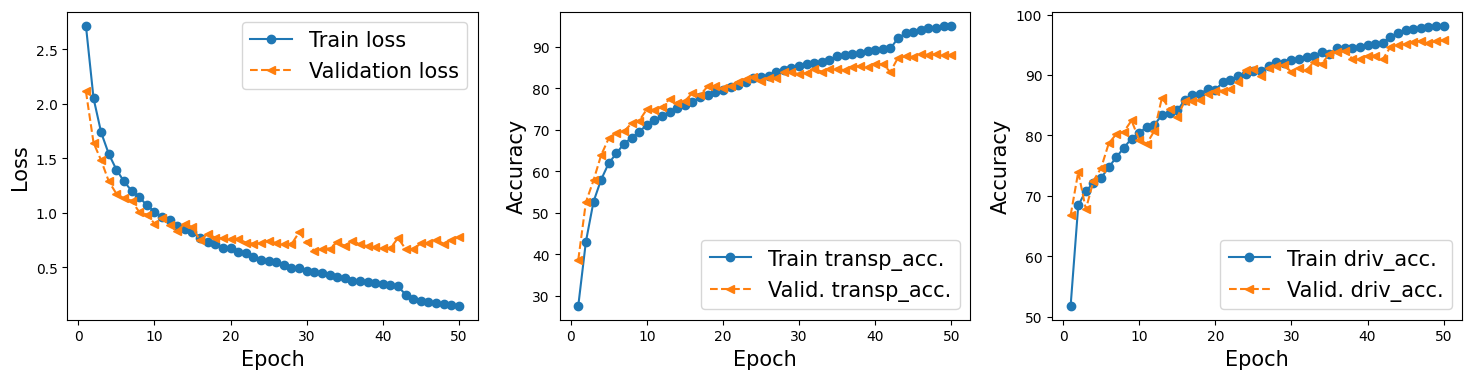

In [9]:
MTL_plot().plot_history(firstRun_hist)

In [10]:
engine.test(test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

   Test Loss: 0.7316, Test Transport Accuracy: 88.57%, Test Driver Accuracy: 95.78%


(0.7316179813250251, 88.56599204289915, 95.77927694170558)

Next calculate precision, recall and f1 score. As well as generalization score using the test set